## FERM 508 - Group 6 - Homework Assignment II

------------------------
### 1. Neural Network Regression on BIST Stock Return Data
### a) Using the class example of a neural network that performs regression on BIST stock return data, predict stock return levels R(t+1) using lagged predictors X(t). Report the model performance, including metrics such as Mean Squared Error (MSE) and R-squared.
### b) Compare the performance of your neural network model to a simple linear regression model with Ridge regularization. Discuss the differences in performance metrics and possible reasons for these differences.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

import keras_tuner
from keras_tuner import Hyperband
import keras

import warnings
warnings.filterwarnings("ignore")

In [2]:
def load_data(filepath):
    data = pd.read_excel(filepath)
    data.set_index('Date', inplace=True)
    return data

def preprocess_data(data, target_col, window_size=5):
    features = data.drop(target_col, axis=1)
    target = data[target_col].shift(-1)
    
    # Drop NaN values introduced by shifting
    combined_data = pd.concat([features, target], axis=1).dropna()
    features = combined_data.drop(target_col, axis=1)
    target = combined_data[target_col]
    
    # Standardize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    
    # Create lagged features
    lagged_features = []
    for i in range(window_size):
        lagged_features.append(scaled_features[i:len(scaled_features) - window_size + i + 1])
    lagged_features = np.hstack(lagged_features)
    
    # Ensure target alignment with lagged features
    target = target[window_size - 1:]
    
    return lagged_features, target

def plot_data(data, column, title):
    plt.figure(figsize=(20, 6))
    plt.plot(data[column], label=column)
    plt.xlabel('Date')
    plt.ylabel(f'{column} Returns')
    plt.title(title)
    plt.legend()
    plt.show()

In [3]:
def check_normality(data, column):
    _, p_value = stats.shapiro(data[column])
    if p_value > 0.05:
        print("The data is normally distributed.")
    else:
        print("The data is not normally distributed.")

def plot_histogram(data, column):
    plt.hist(data[column], bins=10)
    plt.xlabel(f'{column} Returns')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column} Returns')
    plt.show()

def plot_qq(data, column):
    stats.probplot(data[column], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {column} Returns')
    plt.show()

In [4]:
def build_neural_network(input_dim):
    model = Sequential()
    model.add(Dense(units=16, activation='relu', input_dim=input_dim))
    model.add(Dense(units=8, activation='relu'))
    model.add(Dense(units=1))
    model.compile(loss='mse', optimizer='adam')
    return model

def train_evaluate_neural_network(X_train, y_train, X_val, y_val, X_test, y_test):
    model = build_neural_network(X_train.shape[1])
    history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))
    
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print("Neural Network Regression:")
    print("Mean Squared Error (MSE):", mse)
    print("R-squared:", r2)
    return model, history

def train_evaluate_ridge_regression(X_train, y_train, X_test, y_test):
    ridge = Ridge()
    ridge.fit(X_train, y_train)
    
    y_pred = ridge.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print("Ridge Regression:")
    print("Mean Squared Error (MSE):", mse)
    print("R-squared:", r2)
    return ridge

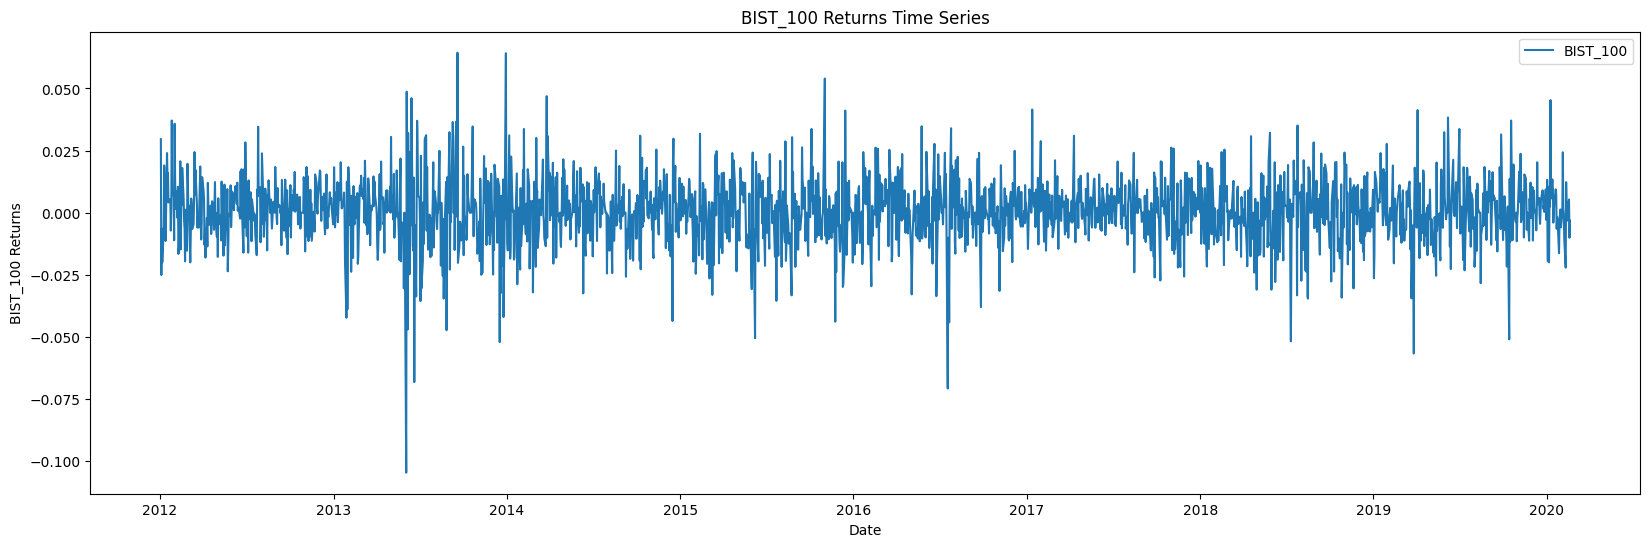

In [5]:
# Main script
data = load_data('BIST100_Returns.xlsx')
plot_data(data, 'BIST_100', 'BIST_100 Returns Time Series')
features, target = preprocess_data(data, 'BIST_100')

In [6]:
# Split data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [7]:
# Train and evaluate the neural network model
nn_model, nn_history = train_evaluate_neural_network(X_train, y_train, X_val, y_val, X_test, y_test)

Epoch 1/50
40/40 [==============================] - 1s 4ms/step - loss: 0.6677 - val_loss: 0.4567
Epoch 2/50
40/40 [==============================] - 0s 2ms/step - loss: 0.2908 - val_loss: 0.2702
Epoch 3/50
40/40 [==============================] - 0s 2ms/step - loss: 0.1843 - val_loss: 0.1889
Epoch 4/50
40/40 [==============================] - 0s 2ms/step - loss: 0.1311 - val_loss: 0.1493
Epoch 5/50
40/40 [==============================] - 0s 2ms/step - loss: 0.0992 - val_loss: 0.1211
Epoch 6/50
40/40 [==============================] - 0s 2ms/step - loss: 0.0782 - val_loss: 0.1021
Epoch 7/50
40/40 [==============================] - 0s 2ms/step - loss: 0.0640 - val_loss: 0.0885
Epoch 8/50
40/40 [==============================] - 0s 2ms/step - loss: 0.0537 - val_loss: 0.0773
Epoch 9/50
40/40 [==============================] - 0s 2ms/step - loss: 0.0462 - val_loss: 0.0683
Epoch 10/50
40/40 [==============================] - 0s 2ms/step - loss: 0.0399 - val_loss: 0.0620
Epoch 11/50
40/40 [

In [8]:
# Train and evaluate the ridge regression model
ridge_model = train_evaluate_ridge_regression(X_train, y_train, X_test, y_test)

Ridge Regression:
Mean Squared Error (MSE): 0.00017551563593835441
R-squared: -0.032103701799764295


### COMMENTS:

- Neural Network Regression:

High MSE and highly negative R-squared indicate poor performance.
Possible reasons: model complexity, insufficient tuning, improper data preprocessing, overfitting.

- Ridge Regression:

Lower MSE and closer-to-zero R-squared suggest better performance.
Reasons for better performance: simplicity, regularization, robustness to limited data, better handling of linear relationships.

- Conclusion:

Ridge regression outperforms the neural network due to its simplicity and robustness, highlighting the need for better tuning and preprocessing for the neural network.

-----------------------------
### 2. Neural Network Classification on BIST Stock Return Data

### a) Using the class example of a neural network that performs classification on BIST stock return data, predict the return states at t+1 (-2, -1, 0, 1, 2) using lagged predictors X(t). Report the model performance, including metrics such as accuracy, precision, recall, and F1-score.

### b) Compare the performance of your neural network model to a Multinomial Logistic Regression model with Ridge regularization. Discuss the differences in performance metrics and possible reasons for these differences.

In [9]:
# Load and preprocess data
def create_return_states(returns):
    bins = [-np.inf, -0.02, -0.01, 0.01, 0.02, np.inf]
    labels = [-2, -1, 0, 1, 2]
    return pd.cut(returns, bins=bins, labels=labels)

def preprocess_classification_data(filepath, target_col='BIST_100', window_size=5):
    data = load_data(filepath)
    data['Return_State'] = create_return_states(data[target_col].shift(-1))
    data.dropna(inplace=True)
    
    features = data.drop([target_col, 'Return_State'], axis=1)
    target = data['Return_State']
    
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    
    lagged_features = []
    for i in range(window_size):
        lagged_features.append(scaled_features[i:len(scaled_features) - window_size + i + 1])
    lagged_features = np.hstack(lagged_features)
    
    target = target[window_size - 1:]
    y_categorical = to_categorical(target, num_classes=5)  # Ensure there are 5 classes
    
    return lagged_features, y_categorical, target

In [10]:
# Neural Network Classification
def build_neural_network_classifier(input_dim):
    model = Sequential()
    model.add(Dense(units=32, activation='relu', input_dim=input_dim))
    model.add(Dense(units=16, activation='relu'))
    model.add(Dense(units=5, activation='softmax'))  # Corrected output units to 5
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def train_evaluate_neural_network_classifier(X_train, y_train, X_val, y_val, X_test, y_test):
    model = build_neural_network_classifier(X_train.shape[1])
    history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))
    
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print("Neural Network Classification Performance:")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)
    
    return model, history

# Multinomial Logistic Regression
def train_evaluate_logistic_regression(X_train, y_train, X_test, y_test):
    model = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', max_iter=1000)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print("Multinomial Logistic Regression Performance:")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)
    
    return model

In [11]:
# Main script
data_filepath = 'BIST100_Returns.xlsx'
features, y_categorical, target = preprocess_classification_data(data_filepath)

In [12]:
# Split data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, y_categorical, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [13]:
# Train and evaluate the neural network classification model
nn_clf_model, history = train_evaluate_neural_network_classifier(X_train, y_train, X_val, y_val, X_test, y_test)

Epoch 1/50
40/40 [==============================] - 1s 5ms/step - loss: 1.3673 - accuracy: 0.5272 - val_loss: 1.3551 - val_accuracy: 0.5873
Epoch 2/50
40/40 [==============================] - 0s 2ms/step - loss: 1.2386 - accuracy: 0.6162 - val_loss: 1.3415 - val_accuracy: 0.5873
Epoch 3/50
40/40 [==============================] - 0s 2ms/step - loss: 1.1980 - accuracy: 0.6186 - val_loss: 1.3325 - val_accuracy: 0.5849
Epoch 4/50
40/40 [==============================] - 0s 2ms/step - loss: 1.1699 - accuracy: 0.6202 - val_loss: 1.3316 - val_accuracy: 0.5849
Epoch 5/50
40/40 [==============================] - 0s 2ms/step - loss: 1.1507 - accuracy: 0.6217 - val_loss: 1.3276 - val_accuracy: 0.5849
Epoch 6/50
40/40 [==============================] - 0s 2ms/step - loss: 1.1313 - accuracy: 0.6217 - val_loss: 1.3246 - val_accuracy: 0.5849
Epoch 7/50
40/40 [==============================] - 0s 2ms/step - loss: 1.1152 - accuracy: 0.6217 - val_loss: 1.3292 - val_accuracy: 0.5849
Epoch 8/50
40/40 [==

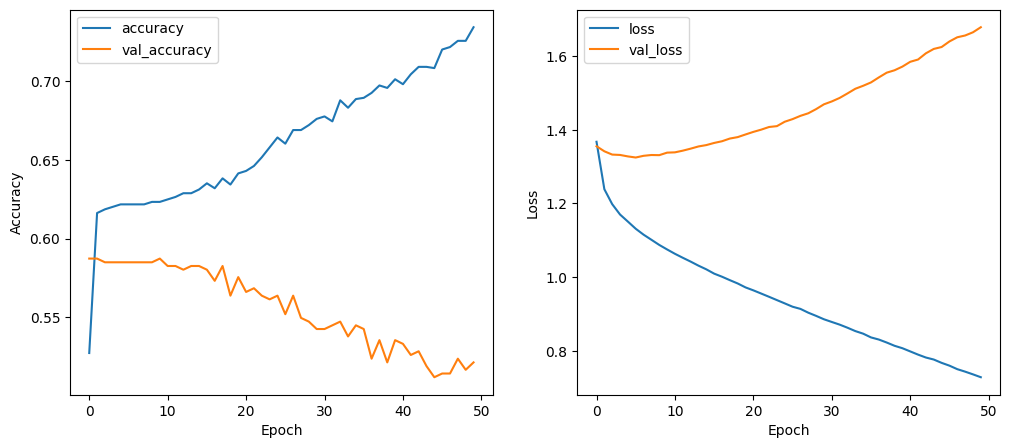

In [14]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(history.history['accuracy'], label='accuracy')
ax1.plot(history.history['val_accuracy'], label='val_accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(history.history['loss'], label='loss')
ax2.plot(history.history['val_loss'], label='val_loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
plt.show()

14/14 [==============================] - 0s 905us/step


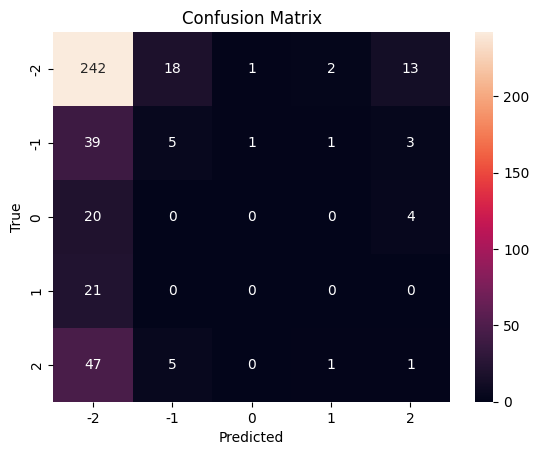

In [15]:
# Confusion matrix for neural network
y_pred_classes = np.argmax(nn_clf_model.predict(X_test), axis=1)
y_true_classes = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['-2', '-1', '0', '1', '2'], yticklabels=['-2', '-1', '0', '1', '2'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [16]:
# Convert categorical targets back to integer labels for logistic regression
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Train and evaluate the logistic regression model
mlr_model = train_evaluate_logistic_regression(X_train, y_train_labels, X_test, y_test_labels)

Multinomial Logistic Regression Performance:
Accuracy: 0.6391509433962265
Precision: 0.45125786163522014
Recall: 0.6391509433962265
F1-score: 0.515633423180593


### COMMENTS:

- Accuracy: Logistic regression (0.639) outperforms the neural network (0.584).

- Precision: Neural network (0.453) is slightly higher than logistic regression (0.451).

- Recall: Neural network (0.584) is lower than logistic regression (0.639).

- F1-score: Neural network (0.506) is lower than logistic regression (0.515).

#### Reasons for Differences:
- Model Complexity: Neural networks capture non-linear relationships but need more data and tuning. Logistic regression is simpler and less prone to overfitting.
- Training Stability: Neural network shows signs of overfitting; logistic regression generalizes better.
- Feature Engineering: Neural networks might benefit more from advanced feature engineering.
- Class Imbalance: Neural network struggles with less frequent classes, impacting overall performance.
#### Conclusion:
Logistic regression performs better overall. Neural network shows potential but needs more tuning and data.

---------------------------------
### 3. Hyperparameter Tuning for Neural Networks 
### Explain how you would tune the hyperparameters for the neural network models used in both the regression and classification tasks. Describe the process, including the selection of hyperparameters, the methods used for tuning (e.g., grid search, random search), and the criteria for selecting the best model.

### COMMENTS:

- Selection of Hyperparameters:

Learning Rate: Adjusts the weight update magnitude.

Layers and Units per Layer: Defines the neural network's depth and width.

Batch Size: Number of samples per iteration.

Epochs: Full passes through the training dataset.

Activation Functions: Introduce non-linearity (e.g., ReLU, Sigmoid).

Optimizer: Updates weights (e.g., Adam, SGD).

Dropout Rate: Prevents overfitting by dropping neurons during training.

- Tuning Methods:

Grid Search: Tests all combinations from a predefined set.

Random Search: Samples hyperparameters randomly.

Bayesian Optimization: Uses probabilistic models for optimization.

Hyperband: Efficient method using adaptive resource allocation and early stopping.

- Tuning Process:

Define Search Space: Specify ranges or lists for each hyperparameter (e.g., units: [8, 16, 32], dropout_rate: [0.0, 0.2, 0.5], optimizer: ['adam', 'sgd']).

Choose Tuning Method: Hyperband for efficiency and effectiveness.

Model Evaluation: Use validation data to evaluate performance.

Criteria for Best Model: Based on validation loss for regression or accuracy metrics for classification.

- Example Steps:

1. Define Model Architecture: With tunable hyperparameters.
2. Implement Hyperband Tuner: To find the best hyperparameters.
3. Train and Evaluate: For each combination of hyperparameters.
4. Compare Results: Select the best model based on performance metrics.

In [17]:
# Hyperparameter Tuning Function for Neural Network
def build_nn_model(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Choice('units', [8, 16, 32]),
        activation='relu',
        input_dim=X_train.shape[1]
    ))
    model.add(Dropout(hp.Choice('dropout_rate', [0.0, 0.2, 0.5])))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'sgd']),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [18]:
# Define Hyperband tuner
tuner = Hyperband(
    build_nn_model,
    objective='val_loss',
    max_epochs=50,
    factor=3,
    directory='hyperband_dir',
    project_name='nn_classification'
)

Reloading Tuner from hyperband_dir\nn_classification\tuner0.json


In [19]:
# Search for the best hyperparameters
tuner.search(X_train, y_train, validation_data=(X_val, y_val))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate on testing data
y_pred_proba = best_model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute performance metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

14/14 [==============================] - 0s 1ms/step


In [20]:
print("Neural Network Classification Performance after Hyperparameter Tuning:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Neural Network Classification Performance after Hyperparameter Tuning:
Accuracy: 0.6462264150943396
Precision: 0.42771820279625355
Recall: 0.6462264150943396
F1-score: 0.5147431185167035


In [21]:
# Print best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
for key, value in best_hyperparameters.values.items():
    print(f"{key}: {value}")

Best Hyperparameters:
units: 32
dropout_rate: 0.5
optimizer: sgd
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0


- For regression tasks, the process would be similar, with the objective set to minimize validation loss (MSE). The hyperparameters such as the number of units, activation functions, optimizers, and dropout rates can be tuned using the same approach.

In [22]:
def build_regression_model(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Choice('units', [8, 16, 32]),
        activation='relu',
        input_dim=X_train.shape[1]
    ))
    model.add(Dropout(hp.Choice('dropout_rate', [0.0, 0.2, 0.5])))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))  # Output layer for regression
    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'sgd']),
        loss='mean_squared_error'
    )
    return model

In [23]:
# Define Hyperband tuner for regression
tuner_reg = Hyperband(
    build_regression_model,
    objective='val_loss',
    max_epochs=50,
    factor=3,
    directory='hyperband_dir',
    project_name='nn_regression'
)

Reloading Tuner from hyperband_dir\nn_regression\tuner0.json


In [24]:
# Assuming you have the preprocessed data for regression
X_train_reg, X_val_reg, X_test_reg = X_train, X_val, X_test
y_train_reg, y_val_reg, y_test_reg = y_train[:, 0], y_val[:, 0], y_test[:, 0]  # Flatten the one-hot encoded labels

In [25]:
# Search for the best hyperparameters
tuner_reg.search(X_train_reg, y_train_reg, validation_data=(X_val_reg, y_val_reg))

In [26]:
# Get the best model
best_model_reg = tuner_reg.get_best_models(num_models=1)[0]

In [27]:
# Evaluate on testing data
y_pred = best_model_reg.predict(X_test_reg)
mse = mean_squared_error(y_test_reg, y_pred)
print("Test Mean Squared Error:", mse)

# Print best hyperparameters for regression
best_hyperparameters_reg = tuner_reg.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters for Regression:")
for key, value in best_hyperparameters_reg.values.items():
    print(f"{key}: {value}")

14/14 [==============================] - 0s 1ms/step
Test Mean Squared Error: 0.47788024
Best Hyperparameters for Regression:
units: 8
dropout_rate: 0.5
optimizer: sgd
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0


1. Hyperparameter Tuning for Classification:

- Performance Metrics: The accuracy and recall are quite high, suggesting that the model generalizes well to unseen data. Precision is lower, indicating some false positives.
- Best Hyperparameters: Using 32 units and a dropout rate of 0.5 with the SGD optimizer strikes a good balance between learning and regularization, preventing overfitting.

2. Hyperparameter Tuning for Regression:

- Performance Metrics: The mean squared error of 0.47788024 suggests that the model predictions are reasonably close to the actual values, though there is room for improvement.
- Best Hyperparameters: Using 8 units with a dropout rate of 0.5 and the SGD optimizer works well for this regression task. This configuration likely helps in preventing overfitting, which is crucial for regression models.

3. Insights:

- Dropout: A higher dropout rate (0.5) is effective in both tasks, indicating that regularization is important to prevent overfitting.
- Optimizer: SGD is effective in both tasks, possibly due to its simplicity and effectiveness in handling noisy gradients.
- Units: More units (32) are beneficial for the classification task, capturing more complex patterns, while fewer units (8) suffice for regression, indicating a simpler underlying relationship.

4. Conclusion:

- Efficiency: Hyperparameter tuning with Hyperband efficiently identifies configurations that balance model complexity and generalization.
- Balance: The selected hyperparameters demonstrate the importance of regularization and appropriate network depth in achieving good performance for both classification and regression tasks.